<a href="https://colab.research.google.com/github/dolmani38/non-linear-regression/blob/master/Regession_test_0813.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install lime

import numpy as np
import pandas as pd
import numpy as np
import pandas as pd
import keras
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization
from keras.layers import Input, Embedding, Dense
from keras.models import Model
from keras.callbacks import Callback
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from lime import lime_tabular, lime_text
from keras.utils import to_categorical
import datetime
import random

# Bayesian Methods for Hackers style sheet
plt.style.use('bmh')

np.random.seed(1234567890)

from keras import backend as K

def r2(y_true, y_pred):
    """
    # custom R2-score metrics for keras backend
    :param y_true: 실측 데이터
    :param y_pred: 모델에 의한 예측 데이테
    :return: R^2 value, 이 값이 높다고 (예:0.99)해서 예측 값이 정확 하다고 할 수 는 없음...
    """
    SS_res = K.sum(K.square(y_true - y_pred))
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return (1 - SS_res / (SS_tot + K.epsilon()))

def soft_500_acc(y_true, y_pred):
    delta = 500
    return K.mean(K.less_equal(K.abs(y_true-y_pred),delta))

def soft_1000_acc(y_true, y_pred):
    delta = 1000
    return K.mean(K.less_equal(K.abs(y_true-y_pred),delta))

def soft_10000_acc(y_true, y_pred):
    delta = 10000
    return K.mean(K.less_equal(K.abs(y_true-y_pred),delta))

def soft_5perc_acc(y_true, y_pred):
    delta = 0.05
    return K.mean(K.less_equal(K.abs((y_true-y_pred)/y_true),delta))

def soft_10perc_acc(y_true, y_pred):
    delta = 0.10
    return K.mean(K.less_equal(K.abs((y_true-y_pred)/y_true),delta))


def structure(df):
    """
    DataFrame의 column 등 전반적인 구조를 표출 한다.
    :param df:
    :return:
    """
    df1 = df.describe(include='all').T
    df1['type'] = df.dtypes
    df1['null count'] = df.isnull().sum()
    if 'freq' in df1.columns:
        df2 = df1[
            ['type', 'count', 'null count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max', 'unique', 'top',
             'freq']]
    else:
        df2 = df1[['type', 'count', 'null count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']]

    return df2

class EmbeddingMapping():
    """
    Helper class for handling categorical variables
    An instance of this class should be defined for each categorical variable we want to use.
    """
    def __init__(self, series):
        # get a list of unique values
        values = series.unique().tolist()
        
        # Set a dictionary mapping from values to integer value
        # In our example this will be {'Mercaz': 1, 'Old North': 2, 'Florentine': 3}
        self.embedding_dict = {value: int_value+1 for int_value, value in enumerate(values)}
        
        # The num_values will be used as the input_dim when defining the embedding layer. 
        # It will also be returned for unseen values 
        self.num_values = len(values) + 1

    def get_mapping(self, value):
        # If the value was seen in the training set, return its integer mapping
        if value in self.embedding_dict:
            return self.embedding_dict[value]
        
        # Else, return the same integer for unseen values
        else:
            return self.num_values
            
class VerboseCallback(keras.callbacks.Callback):
    """
    kerase.model.fit 함수에서, log 출력을 위한 callback
    """
    def __init__(self, epoch):
        self.epoch = epoch
        self.progress("learning:", 0, [])

    def progress(self, text, current=0, log=None):
        g = self.epoch - current
        f = 50 / self.epoch
        c = int(current * f)
        pg = ['=' for i in range(c)] + ['.' for i in range(50 - c)]
        print("\r" + str(text) + "{}/{}[{}]{}".format(current, self.epoch, ''.join(pg), ('' if log is None else str(log).strip())),
              end="", flush=True)
        if self.epoch - current == 0:
            print("")

    def on_epoch_end(self, epoch, logs=None):
        self.progress("learning:", epoch + 1, logs)


class PeriodicLogger(Callback):
    """
    A helper callback class that only prints the losses once in 'display' epochs
    """
    def __init__(self, display=100):
        self.display = display

    def on_train_begin(self, logs={}):      
        self.epochs = 0    

    def on_epoch_end(self, batch, logs={}):    
        self.epochs += 1     
        if self.epochs % self.display == 0:
            print ("Epoch: %d - %s" % (self.epochs, str(logs)))

periodic_logger_10 = PeriodicLogger(10) 
periodic_logger_50 = PeriodicLogger(50)
periodic_logger_250 = PeriodicLogger(250)
periodic_logger_1000 = PeriodicLogger(1000)

     |████████████████████████████████| 276kB 2.7MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-cp36-none-any.whl size=283845 sha256=90a3a1e5b73024ea809f768f54119b19faeb76fe661e678a1d0ea442852ed106
  Stored in directory: /root/.cache/pip/wheels/4c/4f/a5/0bc765457bd41378bf3ce8d17d7495369d6e7ca3b712c60c89
Successfully built lime


## 성립 실험을 위한 시뮬레이션 데이터 생성

극단적인 power law 형태의 distribution을 시뮬레이션 한다.


<img src='https://miro.medium.com/max/2704/1*FLyS1quRikOyL_-dCA73yg.png' width='500'/>


In [2]:
def nafyc_func(row):
    code,real_yy,rate = row['CODE'],row['REAL_YY'],row['COM_RATE']
    return real_yy * rate + 99

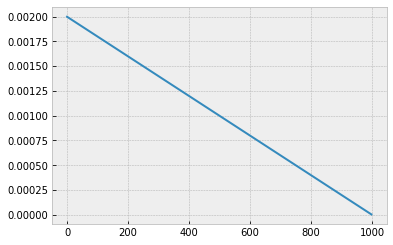

In [3]:
# random choice의 provability distribution
p = [1000-i for i in range(1000-1)]
p = p/np.sum(p)
plt.plot(p)

In [4]:
def create_samples(n_samples):
    rate_table = {}
    samples = []
    for i in range(1000,2520):
      code = i #np.random.choice(range(1000,1520))
      count = np.random.choice(range(10,500))
      for j in range(count):
        real_yy = int((np.random.choice(range(1,1000),p=p)/10)**6/100000 + 100)
        if code not in rate_table:
          rate = np.random.choice(range(1,100)) / 100
          rate_table[code] = rate
        else:
          rate = rate_table[code]
        samples.append([code,real_yy,rate])
        
    return pd.DataFrame(samples, columns=['CODE','REAL_YY','COM_RATE'])

In [5]:
dataset = create_samples(n_samples=100)
dataset['NAFYC'] = dataset.apply(nafyc_func, axis=1)
dataset

,CODE,REAL_YY,COM_RATE,NAFYC
0,1000,555,0.48,365.40
1,1000,880651,0.48,422811.48
2,1000,921006,0.48,442181.88
3,1000,3485,0.48,1771.80
4,1000,221743,0.48,106535.64
...,...,...,...,...
379265,2519,141,0.60,183.60
379266,2519,39846,0.60,24006.60
379267,2519,309,0.60,284.40
379268,2519,224264,0.60,134657.40


## 성립 데이터 EDA

In [6]:
dataset = dataset.astype({"CODE": object})
dataset = dataset.astype({"COM_RATE": object})
structure(dataset)

,type,count,null count,mean,std,min,25%,50%,75%,max,unique,top,freq
CODE,object,379270.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1520.0,2217.00,499.0
REAL_YY,int64,379270.0,0,360557.693429,995173.849469,100.0,160.0,6557.0,160137.000,9940249.00,NaN,NaN,NaN
COM_RATE,object,379270.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,99.0,0.13,6667.0
NAFYC,float64,379270.0,0,181667.674308,585547.139825,100.0,189.0,2567.8,62703.655,9723328.56,NaN,NaN,NaN


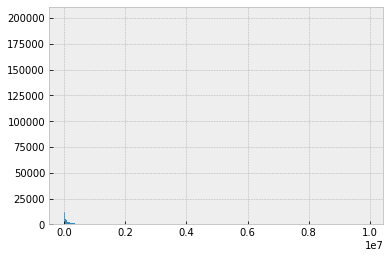

In [7]:
# 극단적인 power law 형태 확인  
dataset['REAL_YY'].hist(bins=1000)

## 데이터 전처리

In [8]:
from sklearn.preprocessing import PolynomialFeatures
from tensorflow.keras.layers.experimental import RandomFourierFeatures

def data_preprocess(ds1):
  # zscore norm
  ds = ds1.copy()
  ds = ds.astype({"COM_RATE": float})
  dst = ds[['REAL_YY','COM_RATE']]

  _mean = dst.mean(axis=0)
  _std = dst.std(axis=0)

  dst = dst - _mean
  dst /= _std

  ds.update(dst)
  ds['ft1'] = ds['REAL_YY']*ds['COM_RATE']
  ds = ds.astype({"COM_RATE": object})
  # code mapping
  code_mapping = EmbeddingMapping(ds['CODE'])
  ds = ds.assign(code_mapping=ds['CODE'].apply(code_mapping.get_mapping))

  rate_mapping = EmbeddingMapping(ds['COM_RATE'])
  ds = ds.assign(rate_mapping=ds['COM_RATE'].apply(rate_mapping.get_mapping))

  # trainset과 validationset 나누고... 기타 정리

  X_train_org, X_val_org, Y_train, Y_val = train_test_split(ds[['REAL_YY','ft1','code_mapping','rate_mapping']],
      ds['NAFYC'], test_size=0.1, random_state=0)

  # 학습 대상 변수만 선택
  X_train_continuous = X_train_org[['REAL_YY','ft1']]
  X_train_categorical = X_train_org[['code_mapping','rate_mapping']]

  X_val_continuous  = X_val_org[['REAL_YY','ft1']]
  X_val_categorical = X_val_org[['code_mapping','rate_mapping']]

  ######################### polynomial
  n = 3
  trX_expanded = np.expand_dims(X_train_continuous, axis=1)
  poly = PolynomialFeatures(n)
  X_train_continuous = poly.fit_transform(X_train_continuous)
  X_val_continuous = poly.fit_transform(X_val_continuous)
  ###########################

  return X_train_continuous,X_train_categorical,X_val_continuous,X_val_categorical,Y_train, Y_val

X_train_continuous,X_train_categorical,X_val_continuous,X_val_categorical,Y_train, Y_val = data_preprocess(dataset)

## Network 구성

In [9]:
def model_build(X_train_continuous,X_train_categorical): 
    # Define the embedding input
    code_input = Input(shape=(X_train_categorical.shape[1],), dtype='int32') 
    output_dim=32*2   #X_train_categorical['code_mapping'].max()*1
    code_embedings = Embedding(output_dim=output_dim, input_dim=X_train_categorical['code_mapping'].max()+1)(code_input)
    code_embedings = keras.layers.Reshape((output_dim*X_train_categorical.shape[1],))(code_embedings)

    # Define the continuous variables input (just like before)
    continuous_input = Input(shape=(X_train_continuous.shape[1], ))

    # Concatenate continuous and embeddings inputs
    all_input = keras.layers.concatenate([continuous_input, code_embedings])
    print(all_input)

    # Define the model
    dense1 = Dense(all_input.shape[1]*3, activation='relu')(all_input)
    dense2 = Dense(5, activation='relu')(dense1)
    predictions = Dense(1)(dense2)

    # Note using the input object 'area_input' not 'area_embeddings'
    model = Model(inputs=[continuous_input, code_input], outputs=predictions)
    model.compile(loss='mse', optimizer=keras.optimizers.Adam(lr=.8, beta_1=0.9, beta_2=0.999, decay=1e-03, amsgrad=True),metrics=[soft_5perc_acc,soft_10perc_acc,soft_500_acc,soft_1000_acc,soft_10000_acc,r2])
    model.summary()
    return model

model = model_build(X_train_continuous,X_train_categorical)

Tensor("concatenate/concat:0", shape=(None, 138), dtype=float32)
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 2, 64)        97344       input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 10)]         0                                            
__________________________________________________________________________________________________
reshape (Reshape)               (None, 128)          0           embedding[0][0]                  
______________________

## 학습

Epoch: 10 - {'loss': 128101488.0, 'soft_5perc_acc': 0.19350215792655945, 'soft_10perc_acc': 0.24076363444328308, 'soft_500_acc': 0.2653385102748871, 'soft_1000_acc': 0.3212750256061554, 'soft_10000_acc': 0.7717064023017883, 'r2': 0.9996200799942017, 'val_loss': 950203904.0, 'val_soft_5perc_acc': 0.1739736646413803, 'val_soft_10perc_acc': 0.22723719477653503, 'val_soft_500_acc': 0.355360746383667, 'val_soft_1000_acc': 0.4140743017196655, 'val_soft_10000_acc': 0.7623612880706787, 'val_r2': 0.9971905946731567}
Epoch: 20 - {'loss': 4771394.5, 'soft_5perc_acc': 0.3916129171848297, 'soft_10perc_acc': 0.45883646607398987, 'soft_500_acc': 0.4678349196910858, 'soft_1000_acc': 0.6889660954475403, 'soft_10000_acc': 0.9928508400917053, 'r2': 0.999985933303833, 'val_loss': 7093943.5, 'val_soft_5perc_acc': 0.4006189703941345, 'val_soft_10perc_acc': 0.4698851406574249, 'val_soft_500_acc': 0.4764036238193512, 'val_soft_1000_acc': 0.7318476438522339, 'val_soft_10000_acc': 0.9880843162536621, 'val_r2': 

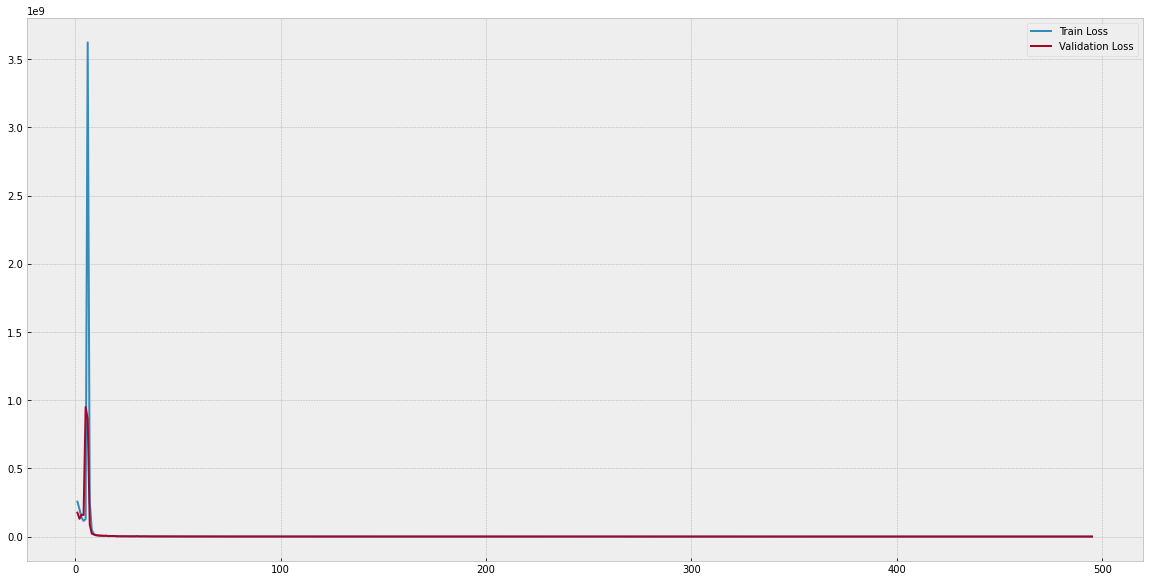

In [10]:
def train_model(model,X_train_continuous, X_train_categorical,X_val_continuous, X_val_categorical,Y_train, Y_val, epochs = 200):
  # Note continuous and categorical columns are inserted in the same order as defined in all_inputs
  history = model.fit([X_train_continuous, X_train_categorical], Y_train, 
            epochs=epochs, batch_size=10000, 
            callbacks=[periodic_logger_10], verbose=0,
            validation_data=([X_val_continuous, X_val_categorical], Y_val))
  # Plot the train/validation loss values
  plt.figure(figsize=(20,10))
  _loss = history.history['loss'][5:]
  _val_loss = history.history['val_loss'][5:]

  train_loss_plot, = plt.plot(range(1, len(_loss)+1), _loss, label='Train Loss')
  val_loss_plot, = plt.plot(range(1, len(_val_loss)+1), _val_loss, label='Validation Loss')

  _ = plt.legend(handles=[train_loss_plot, val_loss_plot])
  return model

train_model(model,X_train_continuous, X_train_categorical,X_val_continuous, X_val_categorical,Y_train,Y_val, epochs = 500)

## 전략의 변경

상대오차 (5%, 10%)는 70%를 넘기지 못하면서, 절대오차 (10000원)은 99% 이상을 보이는 현상은 NAFYC가 극단적인 power law distribution을 갖기 떄문이다.
따라서, 전체 데이터를 한번에 학습하는 것이 아니라 구간별로 나누어 학습하는 방법으로 전략을 변경한다.
이를 통해, 각 구간에서 극단적인 power law 분포를 회피하도록 한다.

## 4개 구간별 학습

1구간 : 100만원 이상<br>
2구간 : 10 ~ 100만원<br>
3구간 : 1 ~ 10만원<br>
4구간 : 1만원이하<br>



array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f80c4629f28>,
      dtype=object)

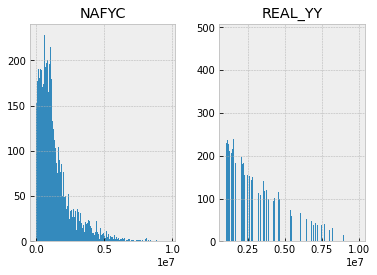

In [11]:
# 1구간
ds_e6 = dataset[dataset['REAL_YY'] > 1000000]
ds_e6.hist(bins=1000)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f80683036a0>,
      dtype=object)

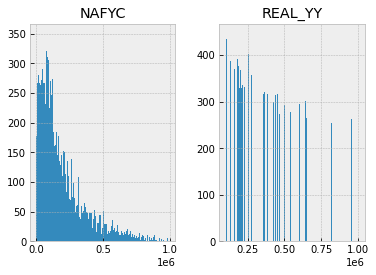

In [12]:
# 2구간
ds_e5 = dataset[(dataset['REAL_YY'] > 100000) & (dataset['REAL_YY'] <= 1000000)]
ds_e5.hist(bins=1000)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f80676ef9e8>,
      dtype=object)

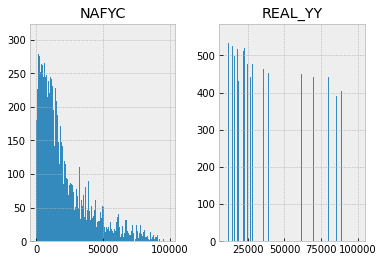

In [13]:
# 3구간
ds_e4 = dataset[(dataset['REAL_YY'] > 10000) & (dataset['REAL_YY'] <= 100000)]
ds_e4.hist(bins=1000)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8065828588>,
      dtype=object)

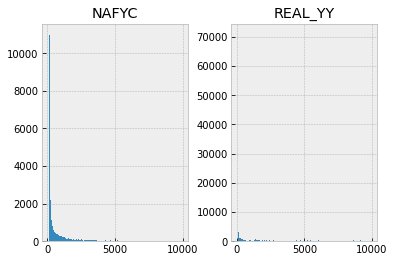

In [14]:
# 4구간
ds_e1 = dataset[dataset['REAL_YY'] <= 10000]
ds_e1.hist(bins=1000)

In [15]:
print('1구간(100만이상) 비율:',ds_e6.shape[0]/dataset.shape[0])
print('2구간( 10만이상) 비율:',ds_e5.shape[0]/dataset.shape[0])
print('3구간(  1만이상) 비율:',ds_e4.shape[0]/dataset.shape[0])
print('4구간(  1만이하) 비율:',ds_e1.shape[0]/dataset.shape[0])

1구간(100만이상) 비율: 0.10186938065230575
2구간( 10만이상) 비율: 0.18617080180346454
3구간(  1만이상) 비율: 0.18247686344820313
4구간(  1만이하) 비율: 0.5294829540960265


Tensor("concatenate_1/concat:0", shape=(None, 138), dtype=float32)
Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 2, 64)        96768       input_3[0][0]                    
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 10)]         0                                            
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 128)          0           embedding_1[0][0]                
____________________

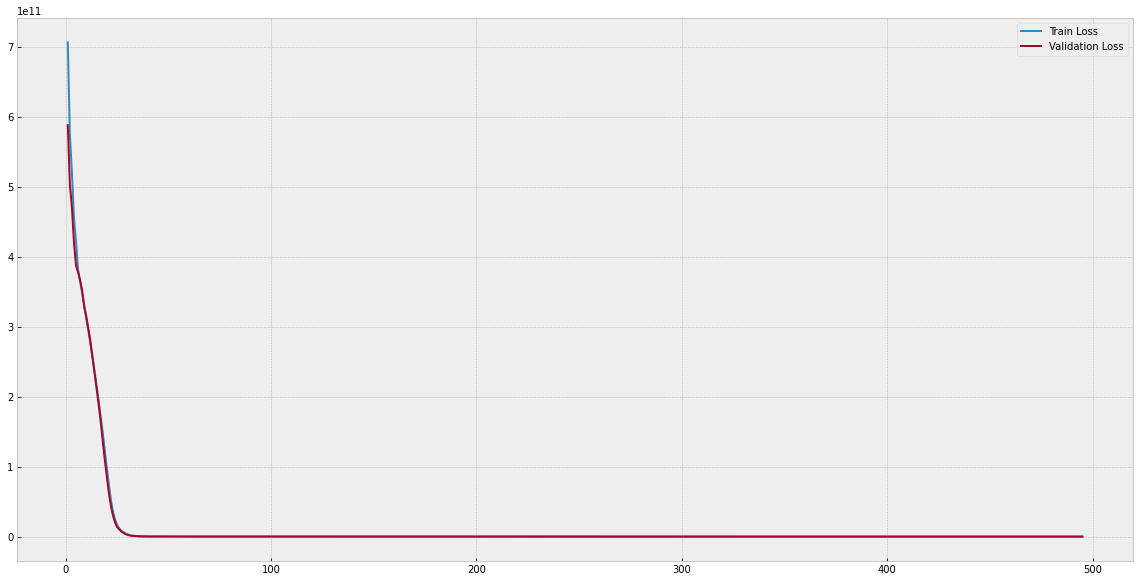

In [16]:
# 1구간 학습

X_train_continuous,X_train_categorical,X_val_continuous_e6,X_val_categorical_e6,Y_train, Y_val_e6 = data_preprocess(ds_e6)
model_e6 = model_build(X_train_continuous,X_train_categorical)
model_build_e6 = train_model(model_e6,X_train_continuous,X_train_categorical,X_val_continuous_e6,X_val_categorical_e6,Y_train, Y_val_e6,epochs = 500)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Tensor("concatenate_5/concat:0", shape=(None, 138), dtype=float32)
Model: "functional_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 2)]          0                                            
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 2, 64)        96960       input_11[0][0]                   
__________________________________________________________________________________________________
input_12 (InputLayer)           [(None, 10)]         0                                            
__________________________________________________________________________________________________
reshape_5 (Reshape)             (None, 128)          0           embedding_5[0][0]                
___________________

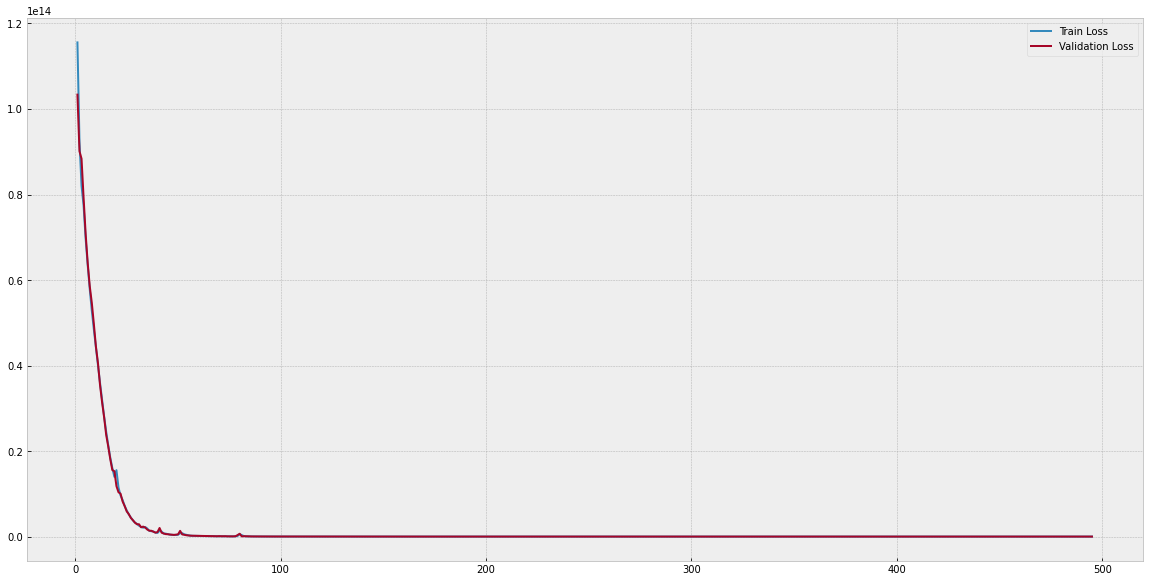

In [28]:
# 2구간 ( 10만원 이상)의 학습
ds_e5['NAFYC'] = ds_e5['NAFYC'] * 100
X_train_continuous,X_train_categorical,X_val_continuous_e5,X_val_categorical_e5,Y_train, Y_val_e5 = data_preprocess(ds_e5)
model_e5 = model_build(X_train_continuous,X_train_categorical)
model_build_e5 = train_model(model_e5,X_train_continuous,X_train_categorical,X_val_continuous_e5,X_val_categorical_e5,Y_train, Y_val_e5,epochs = 500)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Tensor("concatenate_3/concat:0", shape=(None, 138), dtype=float32)
Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 2, 64)        97088       input_7[0][0]                    
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, 10)]         0                                            
__________________________________________________________________________________________________
reshape_3 (Reshape)             (None, 128)          0           embedding_3[0][0]                
____________________

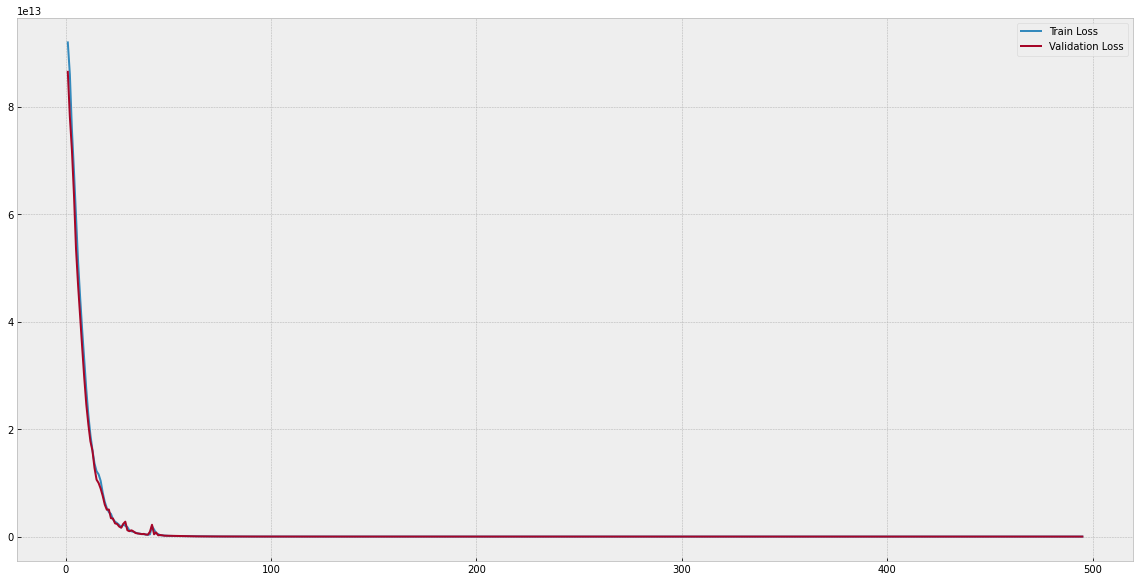

In [18]:
# 3구간 ( 1만원 이상)의 학습
ds_e4['NAFYC'] = ds_e4['NAFYC'] * 1000
X_train_continuous,X_train_categorical,X_val_continuous_e4,X_val_categorical_e4,Y_train, Y_val_e4 = data_preprocess(ds_e4)
model_e4 = model_build(X_train_continuous,X_train_categorical)
model_build_e4 = train_model(model_e4,X_train_continuous,X_train_categorical,X_val_continuous_e4,X_val_categorical_e4,Y_train, Y_val_e4,epochs = 500)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Tensor("concatenate_4/concat:0", shape=(None, 138), dtype=float32)
Model: "functional_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 2, 64)        97344       input_9[0][0]                    
__________________________________________________________________________________________________
input_10 (InputLayer)           [(None, 10)]         0                                            
__________________________________________________________________________________________________
reshape_4 (Reshape)             (None, 128)          0           embedding_4[0][0]                
____________________

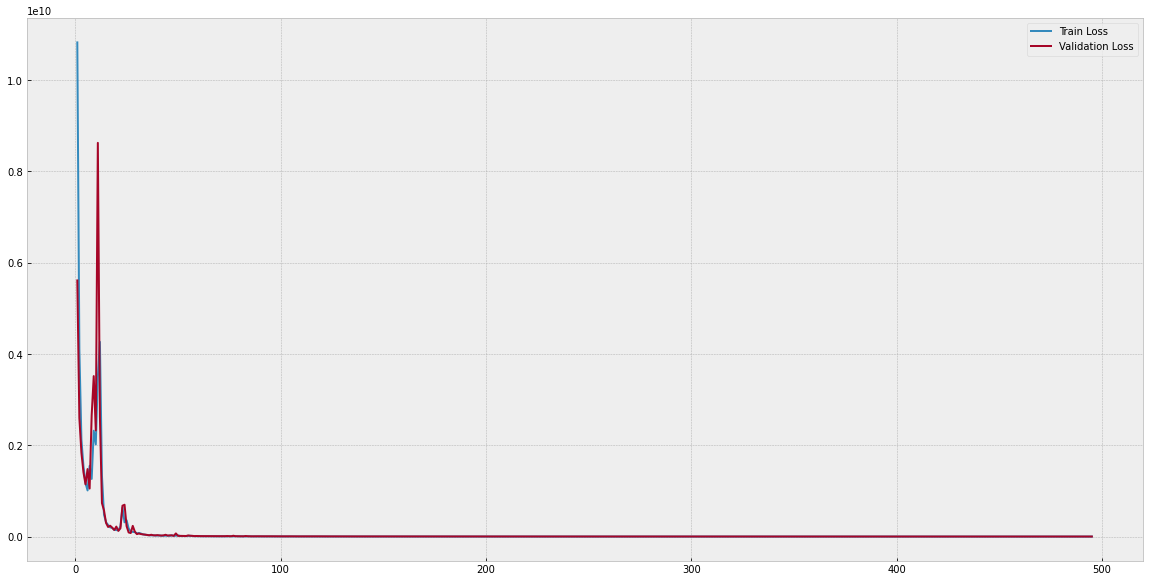

In [19]:
# 4구간 ( 1만원 이하)의 학습

# 전처리 추가
ds_e1['NAFYC'] = ds_e1['NAFYC'] * 1000

X_train_continuous,X_train_categorical,X_val_continuous_e1,X_val_categorical_e1,Y_train, Y_val_e1 = data_preprocess(ds_e1)
model_e1 = model_build(X_train_continuous,X_train_categorical)
model_build_e1 = train_model(model_e1,X_train_continuous,X_train_categorical,X_val_continuous_e1,X_val_categorical_e1,Y_train, Y_val_e1,epochs = 500)

## 4개 구간 전체적인 Evaluation

In [20]:
def range_eveluation(rng,X_val_continuous, X_val_categorical,Y_val,model,adjust_weight=1.0):
    df = pd.DataFrame(Y_val,columns=['NAFYC'])
    df['NAFYC'] = df['NAFYC'] * adjust_weight
    print (str(rng) + "구간 평균 NAFYC: %d" % df['NAFYC'].mean())
    # Add a column for the model's predicted values
    df['pred'] = model.predict([X_val_continuous, X_val_categorical])
    df['pred'] = df['pred'] * adjust_weight
    # Calculate the difference between the predicted and the actual price
    df['diff'] = df['pred'] - df['NAFYC']
    # Calculate the absolute difference between the predicted and the actual price
    df['abs_diff'] = np.abs(df['diff'])
    # Calculate the percentage of the difference from the actual price
    df['%diff'] = 100 * (df['diff'] / df['NAFYC'])
    # Calculate the absolute percentage difference from the actual price
    df['abs_%diff'] = np.abs(df['%diff'])
    # Calculate the mean and std. of the diff field
    diff_mean, diff_std = df['diff'].mean(), df['diff'].std()
    print(str(rng) + "구간 오차평균 ({mean}) 표준편차 {std}.".format(mean=round(diff_mean, 2), std=round(diff_std, 2)))
    print("5% 오차내 정확도 ",1- df[df['abs_%diff'] > 5]['abs_%diff'].count()/df['abs_%diff'].count())
    return df

df1 = range_eveluation(1,X_val_continuous_e6, X_val_categorical_e6,Y_val_e6,model_build_e6)    
df1.sort_values(by=['abs_%diff'], axis=0, ascending=False).head(10)

1구간 평균 NAFYC: 1363567
1구간 오차평균 (20.31) 표준편차 4308.15.
5% 오차내 정확도  0.9733436853002071


,NAFYC,pred,diff,abs_diff,%diff,abs_%diff
108236,87069.58,249905.140625,162835.560625,162835.560625,187.017740,187.017740
18963,70418.59,128427.718750,58009.128750,58009.128750,82.377578,82.377578
234463,76919.52,125064.281250,48144.761250,48144.761250,62.591084,62.591084
147312,20226.00,32147.724609,11921.724609,11921.724609,58.942572,58.942572
262936,22253.82,34117.730469,11863.910469,11863.910469,53.311793,53.311793
116822,23230.30,34600.894531,11370.594531,11370.594531,48.947257,48.947257
353524,23230.30,34404.128906,11173.828906,11173.828906,48.100235,48.100235
93141,31121.86,45774.054688,14652.194687,14652.194687,47.080074,47.080074
18767,56294.60,82269.289062,25974.689063,25974.689063,46.140641,46.140641
147346,23833.20,34716.933594,10883.733594,10883.733594,45.666271,45.666271


In [29]:
df2 = range_eveluation(2,X_val_continuous_e5, X_val_categorical_e5,Y_val_e5,model_build_e5,adjust_weight=0.01)    
df2.sort_values(by=['abs_%diff'], axis=0, ascending=False).head(10)

2구간 평균 NAFYC: 191930
2구간 오차평균 (11.28) 표준편차 280.22.
5% 오차내 정확도  0.9968842940093471


,NAFYC,pred,diff,abs_diff,%diff,abs_%diff
353126,2229.46,2877.557861,648.097861,648.097861,29.069724,29.069724
19500,14124.96,16263.166992,2138.206992,2138.206992,15.137791,15.137791
18983,3151.20,2709.710205,-441.489795,441.489795,-14.010212,14.010212
155818,1164.23,1326.032959,161.802959,161.802959,13.897852,13.897852
31977,2802.14,3171.544678,369.404678,369.404678,13.182949,13.182949
18890,9642.89,10733.216797,1090.326797,1090.326797,11.307054,11.307054
157767,6409.14,7120.429199,711.289199,711.289199,11.098044,11.098044
297718,77465.40,85015.789062,7550.389062,7550.389062,9.746789,9.746789
155799,1263.16,1380.555298,117.395298,117.395298,9.293779,9.293779
142323,10349.30,11190.198242,840.898242,840.898242,8.125170,8.125170


In [22]:
df3 = range_eveluation(3,X_val_continuous_e4, X_val_categorical_e4,Y_val_e4,model_build_e4,adjust_weight=0.001)    
df3.sort_values(by=['abs_%diff'], axis=0, ascending=False).head(10)

3구간 평균 NAFYC: 20151
3구간 오차평균 (1.11) 표준편차 20.86.
5% 오차내 정확도  0.9979771709290565


,NAFYC,pred,diff,abs_diff,%diff,abs_%diff
245605,1097.94,1507.457153,409.517153,409.517153,37.298682,37.298682
217498,952.76,856.944458,-95.815542,95.815542,-10.056629,10.056629
18885,222.26,241.986404,19.726404,19.726404,8.875373,8.875373
155912,1085.11,1176.986084,91.876084,91.876084,8.466983,8.466983
177370,501.24,540.369080,39.129080,39.129080,7.806456,7.806456
10418,462.09,498.001709,35.911709,35.911709,7.771583,7.771583
18935,268.62,289.344330,20.724330,20.724330,7.715111,7.715111
217371,887.06,823.485718,-63.574282,63.574282,-7.166853,7.166853
60490,418.11,447.364685,29.254685,29.254685,6.996887,6.996887
63580,436.38,465.464142,29.084142,29.084142,6.664866,6.664866


In [23]:
df4 = range_eveluation(4,X_val_continuous_e1, X_val_categorical_e1,Y_val_e1,model_build_e1,adjust_weight=0.001)    
df4.sort_values(by=['abs_%diff'], axis=0, ascending=False).head(10)

4구간 평균 NAFYC: 770
4구간 오차평균 (-0.11) 표준편차 1.5.
5% 오차내 정확도  0.999950204162932


,NAFYC,pred,diff,abs_diff,%diff,abs_%diff
378996,420.76,392.184156,-28.575844,28.575844,-6.791483,6.791483
18777,159.16,152.048172,-7.111828,7.111828,-4.468351,4.468351
245379,109.60,113.849937,4.249937,4.249937,3.877680,3.877680
245345,109.33,113.538055,4.208055,4.208055,3.848948,3.848948
245514,108.82,112.933320,4.113320,4.113320,3.779930,3.779930
239271,1974.11,2048.447125,74.337125,74.337125,3.765602,3.765602
245609,114.04,118.313602,4.273602,4.273602,3.747458,3.747458
15654,277.09,266.771313,-10.318688,10.318688,-3.723948,3.723948
111035,191.00,198.044672,7.044672,7.044672,3.688310,3.688310
15488,286.00,275.547219,-10.452781,10.452781,-3.654819,3.654819


In [30]:
df = pd.concat([df1,df2,df3,df4])
diff_mean, diff_std = df['diff'].mean(), df['diff'].std()
print("전체 구간 오차평균 ({mean}) 표준편차 {std}.".format(mean=round(diff_mean, 2), std=round(diff_std, 2)))
print("1% 오차내 정확도 ",1- df[df['abs_%diff'] > 1]['abs_%diff'].count()/df['abs_%diff'].count())
print("5% 오차내 정확도 ",1- df[df['abs_%diff'] > 5]['abs_%diff'].count()/df['abs_%diff'].count())
print("10% 오차내 정확도 ",1- df[df['abs_%diff'] > 10]['abs_%diff'].count()/df['abs_%diff'].count())


전체 구간 오차평균 (4.32) 표준편차 1380.28.
1% 오차내 정확도  0.9674119384096183
5% 오차내 정확도  0.9963087956127399
10% 오차내 정확도  0.9982334950432398


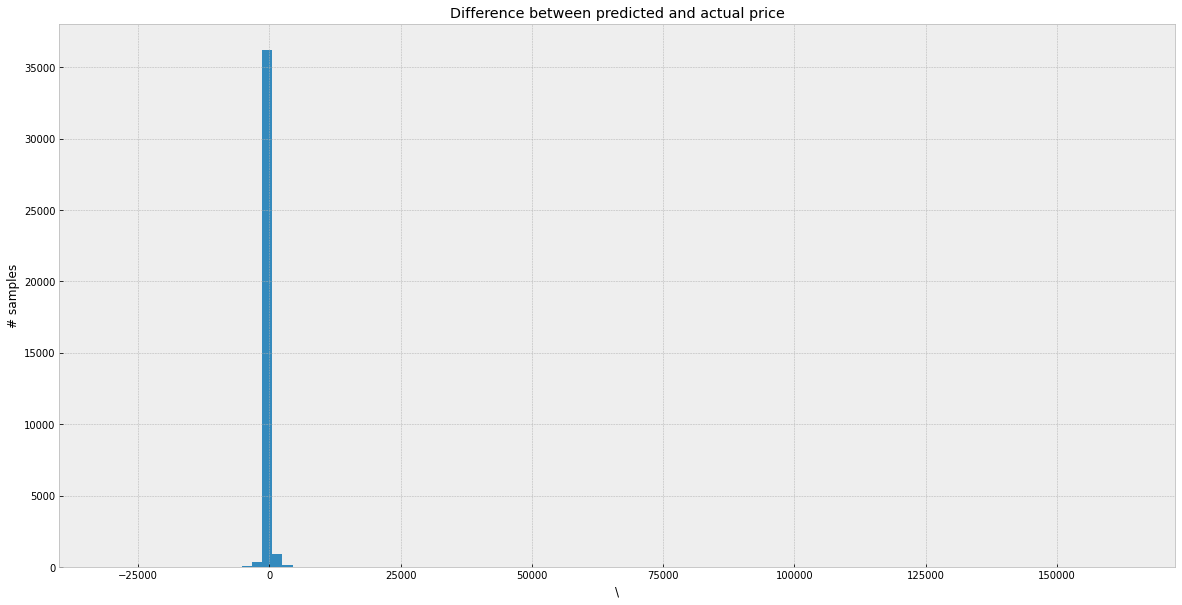

,pred,diff,abs_diff,%diff,abs_%diff,CODE,REAL_YY,COM_RATE,NAFYC
108236,249905.140625,162835.560625,162835.560625,187.017740,187.017740,1417,8697058,0.01,87069.58
18963,128427.718750,58009.128750,58009.128750,82.377578,82.377578,1066,7031959,0.01,70418.59
234463,125064.281250,48144.761250,48144.761250,62.591084,62.591084,1940,7682052,0.01,76919.52
147312,32147.724609,11921.724609,11921.724609,58.942572,58.942572,1581,1006350,0.02,20226.00
262936,34117.730469,11863.910469,11863.910469,53.311793,53.311793,2053,1107741,0.02,22253.82
116822,34600.894531,11370.594531,11370.594531,48.947257,48.947257,1453,1156565,0.02,23230.30
353524,34404.128906,11173.828906,11173.828906,48.100235,48.100235,2405,1156565,0.02,23230.30
93141,45774.054688,14652.194687,14652.194687,47.080074,47.080074,1357,1551143,0.02,31121.86
18767,82269.289062,25974.689063,25974.689063,46.140641,46.140641,1065,1404890,0.04,56294.60
147346,34716.933594,10883.733594,10883.733594,45.666271,45.666271,1581,1186710,0.02,23833.20


In [31]:
# Here is the histogram of the differences
plt.figure(figsize=(20,10))
plt.hist(df['diff'], bins=100)
plt.xlabel("\\")
plt.ylabel("# samples")
_ = plt.title("Difference between predicted and actual price")

plt.show()

# Sort by the 'abs_diff' field and show the 5 largest mistakes in absolute values
a = df.sort_values("abs_%diff", ascending=False)
a.drop(columns=['NAFYC'],inplace=True)
b = a.join(dataset)
b.head(10)

## Non-linearity 대응을 위한 polynomial Regression 적용
https://medium.com/analytics-vidhya/polynomial-regression-with-keras-ef1797b39b88